In [1]:
import os
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
#Da dove arriva il traffico (traffic_source)

In [3]:
events = pd.read_csv("CSV2/events_cleaned.csv", parse_dates=["created_at"])  
users = pd.read_csv("CSV2/users_cleaned.csv", parse_dates=["created_at"])   

Volume totale di interazioni per anno:
   year  num_events
0  2019      169406
1  2020      198162
2  2021      233173
3  2022      278081
4  2023      335908
5  2024      419711
6  2025      609137


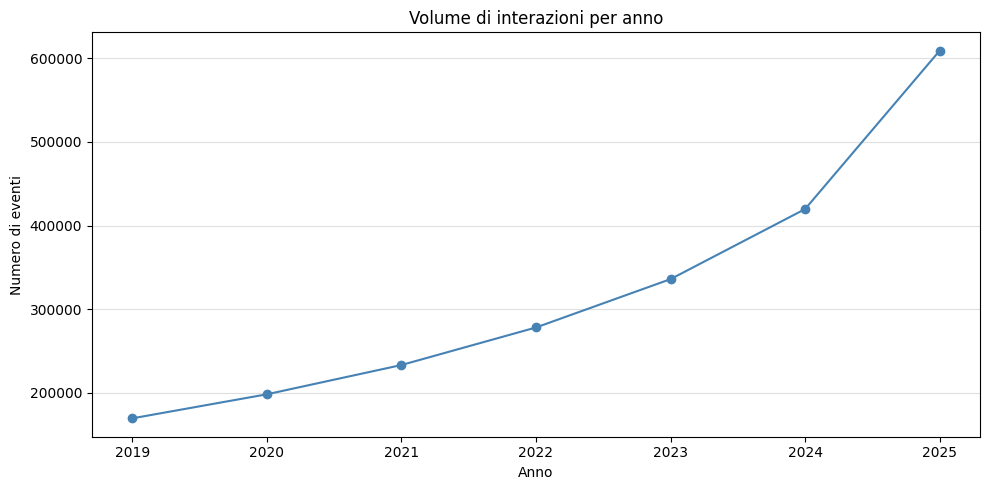

In [4]:
events_filtered = events[events['created_at'] <= '2025-12-31'].copy()  
  
# 3. Estrai l'anno  
events_filtered['year'] = events_filtered['created_at'].dt.year  
  
# 4. Conta il numero di eventi per anno  
events_per_year = (  
    events_filtered  
    .groupby('year')  
    .size()  
    .reset_index(name='num_events')  
    .sort_values('year')  
)  
  
print("Volume totale di interazioni per anno:")  
print(events_per_year)  
  
# 5. Grafico  
plt.figure(figsize=(10, 5))  
plt.plot(events_per_year['year'], events_per_year['num_events'],  
         marker='o', linestyle='-', color='steelblue')  
  
plt.title("Volume di interazioni per anno")  
plt.xlabel("Anno")  
plt.ylabel("Numero di eventi")  
plt.grid(axis='y', alpha=0.4)  
plt.xticks(events_per_year['year'])  
plt.tight_layout()  
plt.show()

In [5]:
# Raggruppa per ip_address e traffic_source per contare sessioni uniche

unique_sessions = (
    events.groupby(["ip_address", "traffic_source"])
          .size()
          .reset_index(name="event_count")
)

# Contiamo quante sessioni uniche ci sono per ogni traffic_source
traffic_source_sessions = unique_sessions.groupby("traffic_source")["ip_address"].nunique().reset_index()
traffic_source_sessions = traffic_source_sessions.rename(columns={"ip_address": "unique_sessions"})

# Ordina per numero di sessioni decrescenti
traffic_source_sessions = traffic_source_sessions.sort_values("unique_sessions", ascending=False)


In [6]:
# 1. Calcoliamo il totale delle sessioni uniche
total_unique_sessions = traffic_source_sessions["unique_sessions"].sum()

# 2. Calcoliamo la percentuale per ogni riga
traffic_source_sessions['%'] = (
    (traffic_source_sessions["unique_sessions"] / total_unique_sessions) * 100
).round(2)

print(f"Totale sessioni uniche analizzate: {total_unique_sessions}")
print("\nDistribuzione percentuale del traffico per sessioni uniche:")
display(traffic_source_sessions)

Totale sessioni uniche analizzate: 680839

Distribuzione percentuale del traffico per sessioni uniche:


,traffic_source,unique_sessions,%
1,Email,307266,45.13
0,Adwords,203450,29.88
2,Facebook,68258,10.03
4,YouTube,67729,9.95
3,Organic,34136,5.01


In [7]:
# siti più visitati

Distribuzione degli event_type:


event_type
product       842470
cart          592554
department    592140
purchase      180858
cancel        125500
home           87451
Name: count, dtype: int64

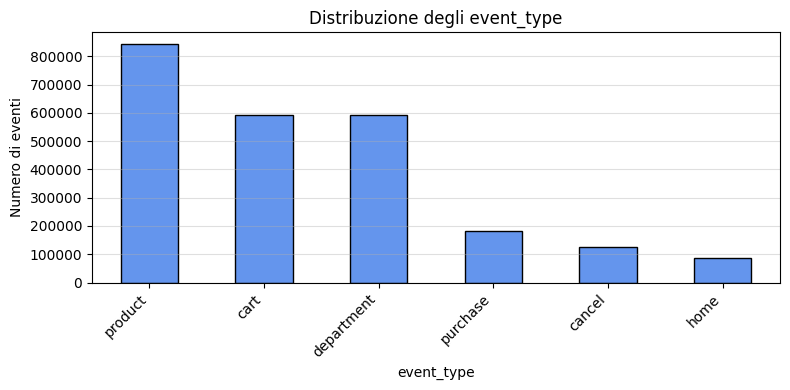

In [8]:
print("Distribuzione degli event_type:")  
event_type_counts = events['event_type'].value_counts()  
display(event_type_counts)  
  
plt.figure(figsize=(8, 4))  
event_type_counts.plot(kind='bar', color='cornflowerblue', edgecolor='black')  
plt.title("Distribuzione degli event_type")  
plt.xlabel("event_type")  
plt.ylabel("Numero di eventi")  
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', alpha=0.4)  
plt.tight_layout()  
plt.show()

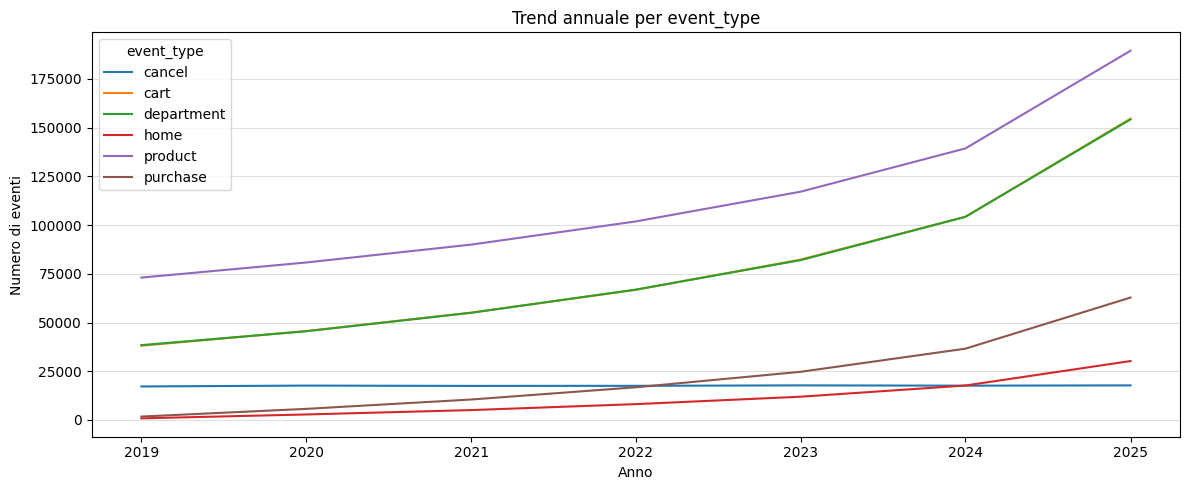

In [9]:
events_filtered['year'] = events_filtered['created_at'].dt.to_period('Y').dt.to_timestamp()

yearly_by_type = (
    events_filtered
    .groupby(['year', 'event_type'])
    .size()
    .reset_index(name='num_events')
)

# Pivot per grafico
pivot_yearly = yearly_by_type.pivot(index='year', columns='event_type', values='num_events').fillna(0)

plt.figure(figsize=(12, 5))
for col in pivot_yearly.columns:
    plt.plot(pivot_yearly.index, pivot_yearly[col], label=col)

plt.title("Trend annuale per event_type")
plt.xlabel("Anno")
plt.ylabel("Numero di eventi")
plt.legend(title="event_type")
plt.grid(axis='y', alpha=0.4)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
by_source_and_type = (
    events
    .groupby(['traffic_source', 'event_type'])
    .size()
    .reset_index(name='num_events')
)

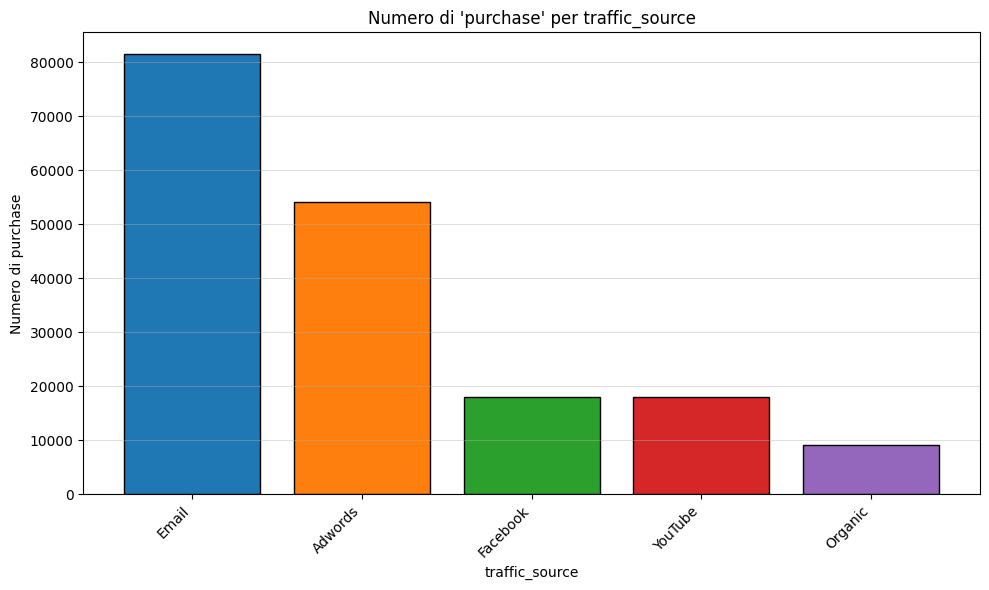

In [11]:
# Filtra solo l'event_type 'purchase'
purchase_by_source = by_source_and_type[by_source_and_type['event_type'] == 'purchase'].copy()

# Ordina (opzionale) per avere il grafico più leggibile
purchase_by_source = purchase_by_source.sort_values('num_events', ascending=False)

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(range(len(purchase_by_source)))
plt.bar(purchase_by_source['traffic_source'], purchase_by_source['num_events'],
        color=colors, edgecolor='black')

plt.title("Numero di 'purchase' per traffic_source")
plt.xlabel("traffic_source")
plt.ylabel("Numero di purchase")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

In [12]:
purchases = events[events['event_type'].str.lower() == 'purchase'].copy()

# 2. Rimuoviamo eventuali purchase senza user_id
purchases = purchases[purchases['user_id'].notna()]

# 3. Conta il numero di purchase per user_id
purchase_per_user = (
    purchases
    .groupby('user_id')
    .size()
    .reset_index(name='num_purchases')
)

# 4. Merge con users_cleaned per avere i dettagli utente
purchase_per_user = purchase_per_user.merge(
    users[['user_id', 'first_name', 'last_name', 'email']],
    on='user_id',
    how='left'
)

# 5. Nome completo e ordinamento
purchase_per_user['full_name'] = (
    purchase_per_user['first_name'].fillna('') + ' ' +
    purchase_per_user['last_name'].fillna('')
).str.strip()

purchase_per_user = purchase_per_user.sort_values('num_purchases', ascending=False).reset_index(drop=True)

print("\n📋 Top loyal customers:")
display(purchase_per_user.head(10)[['user_id', 'full_name', 'email', 'num_purchases']])


📋 Top loyal customers:


,user_id,full_name,email,num_purchases
0,26266.0,Lisa Owens,lisaowens@example.org,13
1,50966.0,Alicia Munoz,aliciamunoz@example.net,13
2,66703.0,Shannon Brown,shannonbrown@example.net,13
3,24532.0,Roberto Santos,robertosantos@example.net,12
4,54458.0,Michael Ramirez,michaelramirez@example.org,12
5,33235.0,Cassandra Ross,cassandraross@example.net,12
6,63941.0,Amanda Booker,amandabooker@example.com,12
7,24286.0,Kristy Carroll,kristycarroll@example.net,12
8,59447.0,Jason Mccoy,jasonmccoy@example.org,12
9,80545.0,Christopher Kirk,christopherkirk@example.org,12


In [13]:
# 2. Creiamo un identificativo di sessione basato su IP + Giorno
events['date'] = events['created_at'].dt.date
events['session_proxy'] = events['ip_address'].astype(str) + "_" + events['date'].astype(str)

# (opzionale ma consigliato) Tieni solo le righe con event_type non nullo
events = events[events['event_type'].notna()].copy()

# 3. Ordiniamo per sessione e tempo
events = events.sort_values(['session_proxy', 'created_at'])

# 4. Calcoliamo la differenza di tempo tra un evento e il successivo nella stessa sessione
events['next_click_time'] = events.groupby('session_proxy')['created_at'].shift(-1)
events['time_spent_sec'] = (events['next_click_time'] - events['created_at']).dt.total_seconds()

# 5. Escludiamo tempi troppo lunghi (> 30 minuti) o negativi / NaN
events = events[(events['time_spent_sec'].notna()) & 
                (events['time_spent_sec'] >= 0) & 
                (events['time_spent_sec'] < 1800)]

# 6. Calcolo del tempo medio speso per event_type
avg_time_per_event_type = (
    events
    .groupby('event_type')['time_spent_sec']
    .mean()
    .reset_index()
    .rename(columns={'time_spent_sec': 'avg_time_seconds'})
    .sort_values('avg_time_seconds', ascending=False)
)

print("Tempo MEDIO tra un evento e il successivo per ogni event_type (in secondi):")
display(avg_time_per_event_type)

Tempo MEDIO tra un evento e il successivo per ogni event_type (in secondi):


,event_type,avg_time_seconds
2,department,423.081646
4,product,419.125769
1,cart,334.658557
3,home,89.406191
0,cancel,0.000000
5,purchase,0.000000
